In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import json
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('transactions.csv')
payDaatDF = pd.json_normalize(df['payment_data'].apply(json.loads))

merchantDF_temp = df[['id', 'merchant']].dropna()
merchantDF = pd.json_normalize(merchantDF_temp['merchant'].apply(json.loads))

In [ ]:
def grafico_total_metodo_pagamento(df):
  # Extrair dados de pagamento
  payDaatDF = pd.json_normalize(df['payment_data'].apply(json.loads))
  payDaatDF['id'] = df['id']

  # Unir com transações
  df_pagamento = pd.merge(df[['id', 'amount']], payDaatDF[['id', 'paymentMethod']], on='id', how='left')
  df_pagamento['amount'] = df_pagamento['amount'].abs()

  # Agrupar por método de pagamento
  valor_por_metodo = df_pagamento.groupby('paymentMethod')['amount'].sum().reset_index()
  valor_por_metodo = valor_por_metodo.sort_values(by='amount', ascending=False)

  # Exibir os resultados
  print("Valor total movimentado por método de pagamento:")
  for _, row in valor_por_metodo.iterrows():
      metodo = row['paymentMethod']
      valor = row['amount']
      print(f"→ {metodo}: R$ {valor:,.2f}")

  # Gráfico de barras
  plt.figure(figsize=(10, 6))
  bars = plt.bar(valor_por_metodo['paymentMethod'], valor_por_metodo['amount'], color='cornflowerblue')

  # Adicionar valores no topo das barras
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2, yval + yval*0.01, f'R$ {yval:,.2f}', ha='center', va='bottom', fontsize=10)

  # Estilização
  plt.title('Valor Total por Método de Pagamento', fontsize=16, weight='bold')
  plt.xlabel('Método de Pagamento', fontsize=14)
  plt.ylabel('Total Movimentado (R$)', fontsize=14)
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

In [ ]:
def grafico_dias_maior_gasto(df):
  df['date'] = pd.to_datetime(df['date'], format='mixed')
  df['amount'] = df['amount'].abs()

  # Agrupar e selecionar os 10 dias com maior gasto
  top_dias = df.groupby('date')['amount'].sum().sort_values(ascending=False).head(10).reset_index()

  # Exibir os resultados
  print("Top 10 dias com maior gasto:")
  display(top_dias)

  # Gráfico de barras horizontal
  plt.figure(figsize=(12, 6))
  plt.barh(top_dias['date'].dt.strftime('%Y-%m-%d'), top_dias['amount'], color='mediumseagreen')
  plt.gca().invert_yaxis()

  # Estilização
  plt.title('Top 10 Dias com Maior Gasto', fontsize=16, weight='bold')
  plt.xlabel('Total Gasto (R$)', fontsize=14)
  plt.ylabel('Data', fontsize=14)
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.tight_layout()

In [ ]:
def grafico_top_categorias_metodo_pagamento(df):
  payDaatDF['id'] = df['id']
  df_merged = pd.merge(df[['id', 'amount', 'category']], payDaatDF[['id', 'paymentMethod']], on='id', how='left')
  df_merged['amount'] = df_merged['amount'].abs()

  # Agrupar os dados por categoria e somar os valores
  total_por_categoria = df_merged.groupby('category')['amount'].sum().reset_index()

  # Selecionar as 10 categorias com maior gasto
  top_categorias = total_por_categoria.sort_values(by='amount', ascending=False).head(5)['category']

  # Filtrar o dataframe original para essas categorias
  df_top = df_merged[df_merged['category'].isin(top_categorias)]

  # Agrupar cruzando método de pagamento e categoria
  gastos_cruzados = df_top.groupby(['paymentMethod', 'category'])['amount'].sum().reset_index()

  # Exibir os resultados
  print("Gastos cruzados por método de pagamento e categoria:")
  display(gastos_cruzados.head(15))  # Exibe os 15 maiores cruzamentos

  # Gráfico de barras agrupadas
  plt.figure(figsize=(14, 7))
  sns.barplot(data=gastos_cruzados, x='category', y='amount', hue='paymentMethod', palette='Set2')

  # Estilização
  plt.title('Gastos nas Top 10 Categorias por Método de Pagamento', fontsize=16, weight='bold')
  plt.xlabel('Categoria', fontsize=14)
  plt.ylabel('Total Gasto (R$)', fontsize=14)
  plt.xticks(rotation=45)
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.legend(title='Método de Pagamento')
  plt.tight_layout()
  plt.show()

In [9]:
def resumo_metricas(df):

    resultado = {}
    payDaatDF = pd.json_normalize(df['payment_data'].apply(json.loads))

    # Garantir que o ID esteja presente
    payDaatDF['id'] = df['id']

    #Valor total por método de pagamento
    df_pagamento = pd.merge(df[['id', 'amount']], payDaatDF[['id', 'paymentMethod']], on='id', how='left')
    df_pagamento['amount'] = df_pagamento['amount'].abs()
    valor_por_metodo = df_pagamento.groupby('paymentMethod')['amount'].sum().reset_index()
    valor_por_metodo = valor_por_metodo.sort_values(by='amount', ascending=False)

    resultado['valor_por_metodo'] = valor_por_metodo.to_dict(orient='records')

    #Top 10 dias com maior gasto
    df['date'] = pd.to_datetime(df['date'], format='mixed')
    df['amount'] = df['amount'].abs()
    gastos_por_dia = df.groupby('date')['amount'].sum().reset_index()
    top_10_dias = gastos_por_dia.sort_values(by='amount', ascending=False).head(10)

    resultado['top_10_dias'] = top_10_dias.to_dict(orient='records')

    #Gastos cruzados por método de pagamento e categoria
    df_merged = pd.merge(df[['id', 'amount', 'category']], payDaatDF[['id', 'paymentMethod']], on='id', how='left')
    df_merged['amount'] = df_merged['amount'].abs()
    gastos_cruzados = df_merged.groupby(['paymentMethod', 'category'])['amount'].sum().reset_index()
    gastos_cruzados = gastos_cruzados.sort_values(by='amount', ascending=False)

    resultado['gastos_cruzados'] = gastos_cruzados.head(15).to_dict(orient='records')

    return resultado

💳 Valor total movimentado por método de pagamento:
→ PIX: R$ 311,920.36
→ OTHER: R$ 33,930.12
→ BOLETO: R$ 6,957.21
→ TED: R$ 193.24


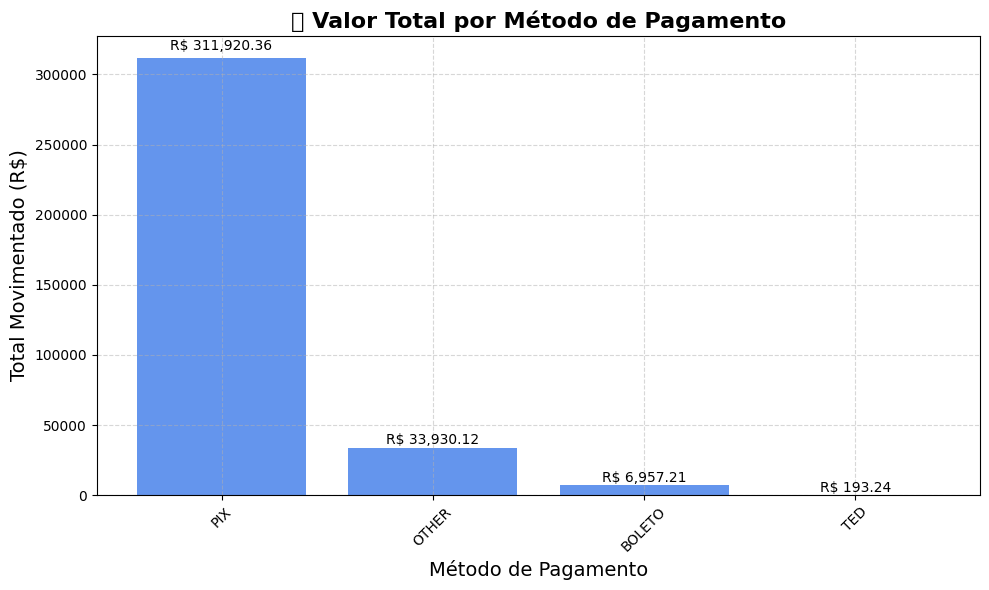

In [10]:
grafico_total_metodo_pagamento(df)

🔝 Top 10 dias com maior gasto:


,date,amount
0,2025-05-30 12:17:23.421,22122.59
1,2025-05-30 12:18:01.244,21300.00
2,2025-05-02 12:31:39.220,13093.91
3,2025-05-02 12:33:00.364,10397.00
4,2025-07-04 19:49:49.441,9368.32
5,2025-05-17 22:57:52.573,5779.35
6,2025-07-04 19:49:52.801,5468.81
7,2025-07-03 21:58:12.021,5357.92
8,2025-04-30 16:11:34.838,5000.00
9,2025-07-18 18:49:19.437,5000.00


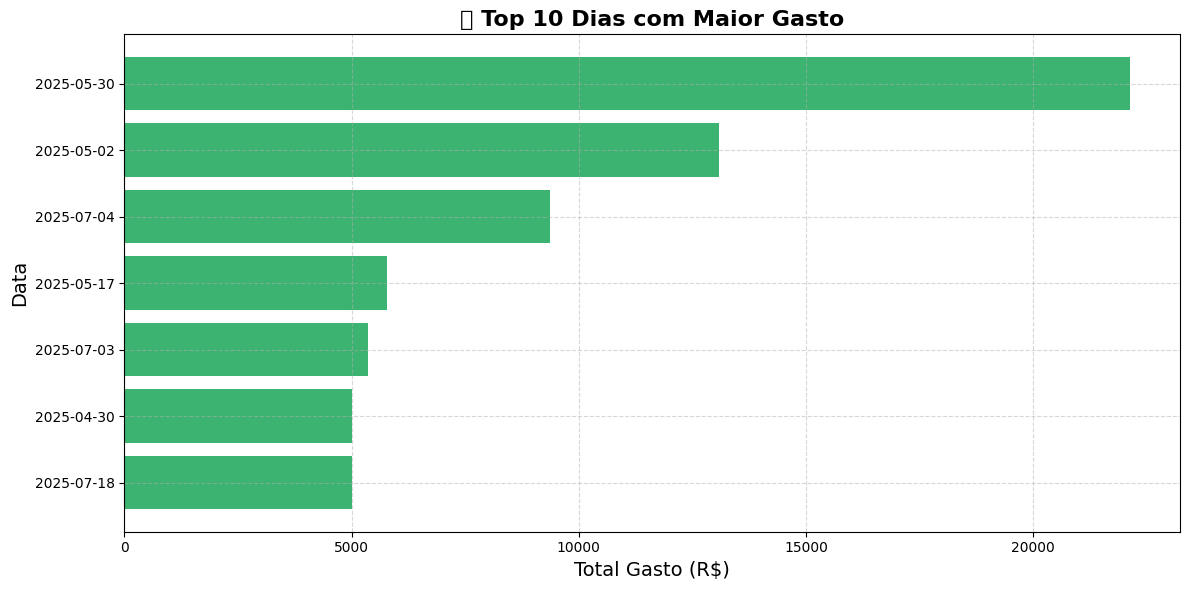

In [11]:
grafico_dias_maior_gasto(df)

🔗 Gastos cruzados por método de pagamento e categoria:


,paymentMethod,category,amount
0,OTHER,Compras,8681.24
1,OTHER,Supermercado,4722.23
2,PIX,Compras,154.00
3,PIX,Supermercado,3542.50
4,PIX,Transferência - Câmbio,41977.80
5,PIX,Transferência - PIX,148785.71
6,PIX,Transferência mesma titularidade,88782.61


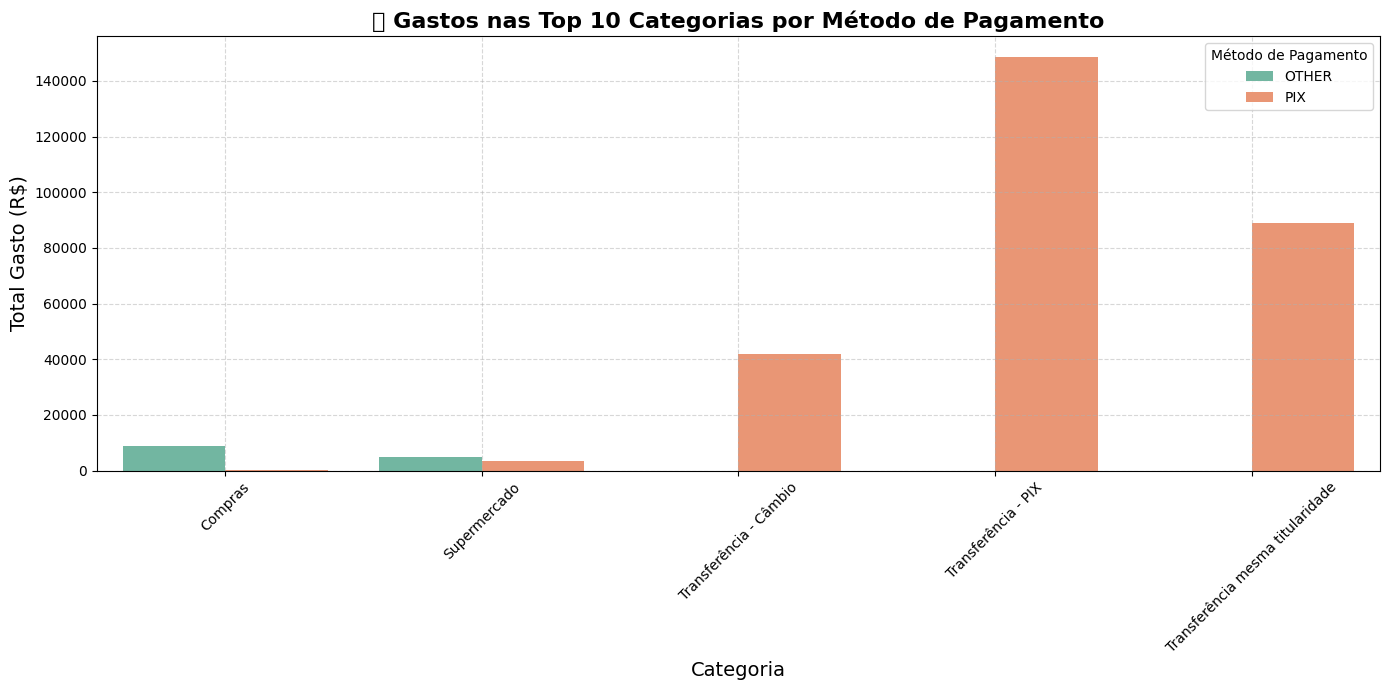

In [12]:
grafico_top_categorias_metodo_pagamento(df)

In [13]:
resumo_metricas(df)

{'valor_por_metodo': [{'paymentMethod': 'PIX', 'amount': 311920.36},
  {'paymentMethod': 'OTHER', 'amount': 33930.12},
  {'paymentMethod': 'BOLETO', 'amount': 6957.210000000001},
  {'paymentMethod': 'TED', 'amount': 193.24}],
 'top_10_dias': [{'date': Timestamp('2025-05-30 12:17:23.421000'),
   'amount': 22122.59},
  {'date': Timestamp('2025-05-30 12:18:01.244000'), 'amount': 21300.0},
  {'date': Timestamp('2025-05-02 12:31:39.220000'), 'amount': 13093.91},
  {'date': Timestamp('2025-05-02 12:33:00.364000'), 'amount': 10397.0},
  {'date': Timestamp('2025-07-04 19:49:49.441000'), 'amount': 9368.32},
  {'date': Timestamp('2025-05-17 22:57:52.573000'), 'amount': 5779.35},
  {'date': Timestamp('2025-07-04 19:49:52.801000'), 'amount': 5468.81},
  {'date': Timestamp('2025-07-03 21:58:12.021000'), 'amount': 5357.92},
  {'date': Timestamp('2025-04-30 16:11:34.838000'), 'amount': 5000.0},
  {'date': Timestamp('2025-07-18 18:49:19.437000'), 'amount': 5000.0}],
 'gastos_cruzados': [{'paymentMetho